## GANs : Generative Adversarial Networks


A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity.
The loss function that the generator wants to minimize and the discriminator to maximize is as follows:

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))]

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively.




## DCGAN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize
transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
      ## Normalize the image into [-1,1] range. This is recommended as the tanh function produces output in this range.
])

# batchsize of dataset
batch_size = 150

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 324096219.61it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 17056560.66it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 149869791.46it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16710990.15it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




## 1. Model Definition (TODO)

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()

        self.convT1 = nn.ConvTranspose2d(100, 512, 3,2)
        self.convT2 = nn.ConvTranspose2d(512,128,2,2)
        self.convT3 = nn.ConvTranspose2d(128,64,3,2)
        self.convT4 = nn.ConvTranspose2d(64,1,3)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor = 2)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, input):

        #output shape: 1, 28, 28; input shape: 100, 1, 1

        out = self.convT1(input)
        out = self.LeakyReLU(out)
        out = self.convT2(out)
        out = self.LeakyReLU(out)
        out = self.convT3(out)
        out = self.LeakyReLU(out)
        out = self.upsample(out)
        out = self.LeakyReLU(out)
        out = self.convT4(out)
        out = nn.Tanh()(out)
        # Explain why Tanh is needed for the last layer
        #Using Tanh in the last layer ensures that the values in the generator are bounded from -1 to 1, which centers the values at 0 which helps backpropagate the loss.
        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16,32,3, 2,1)
        self.conv3 = nn.Conv2d(32,64,3,2,1)
        self.lin1 = nn.Linear(1024, 512)
        self.lin2 = nn.Linear(512,1)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, input):


        #input: 1 x 28 x28, output: 1

        out = self.conv1(input) #output: 32 x 13 x 13
        out = self.LeakyReLU(out)
        out = self.conv2(out)#output: 64 x 5 x 5
        out = self.LeakyReLU(out)
        out = self.conv3(out)#output: 128 x 2 x2
        out = self.LeakyReLU(out)
        # print(out.shape)
        out = out.view(out.shape[0],1024)
        out = self.lin1(out)
        out = self.LeakyReLU(out)
        out = self.lin2(out)
        out = nn.Sigmoid()(out)

        # Explain why Sigmoid is needed for the last layer
        #Sigmoid bounds the output values between 0 and 1 so they can represent probabilities and also allows a gradient to be calculated when being optimized.

        return out


# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


## 2. GAN loss (TODO)

In [ ]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''

    D_real = D(real).reshape(-1)
    loss_real = criterion(D_real, Valid_label)
    fake_imgs = G(noise)
    D_fake = D(fake_imgs.detach()).reshape(-1)
    loss_fake = criterion(D_fake, Fake_label)
    loss_D = loss_real + loss_fake

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    optimizerG.zero_grad()

    D_output = netD(fake).reshape(-1)
    loss_G = criterion(D_output, Valid_label)

    return loss_G

## 3. Training (TODO)

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         461,312
         LeakyReLU-2            [-1, 512, 3, 3]               0
   ConvTranspose2d-3            [-1, 128, 6, 6]         262,272
         LeakyReLU-4            [-1, 128, 6, 6]               0
   ConvTranspose2d-5           [-1, 64, 13, 13]          73,792
         LeakyReLU-6           [-1, 64, 13, 13]               0
UpsamplingBilinear2d-7           [-1, 64, 26, 26]               0
         LeakyReLU-8           [-1, 64, 26, 26]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]             577
Total params: 797,953
Trainable params: 797,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.97
Params size (MB): 3.04
Estimated Total Size (MB): 4.02
-----------------------------------------

[0/20][0/400]	Loss_D: 1.3875	Loss_G: 0.6848	
[0/20][50/400]	Loss_D: 0.1719	Loss_G: 3.8791	
[0/20][100/400]	Loss_D: 0.1358	Loss_G: 3.3762	
[0/20][150/400]	Loss_D: 0.2012	Loss_G: 3.0349	
[0/20][200/400]	Loss_D: 0.8033	Loss_G: 2.5452	
[0/20][250/400]	Loss_D: 1.2073	Loss_G: 1.2501	
[0/20][300/400]	Loss_D: 1.0009	Loss_G: 1.1506	
[0/20][350/400]	Loss_D: 0.8216	Loss_G: 1.4037	
[1/20][0/400]	Loss_D: 1.0998	Loss_G: 1.0852	
[1/20][50/400]	Loss_D: 1.1771	Loss_G: 1.0038	
[1/20][100/400]	Loss_D: 1.0140	Loss_G: 1.1138	
[1/20][150/400]	Loss_D: 0.9897	Loss_G: 1.2202	
[1/20][200/400]	Loss_D: 1.1349	Loss_G: 1.0320	
[1/20][250/400]	Loss_D: 0.9058	Loss_G: 1.2007	
[1/20][300/400]	Loss_D: 1.1493	Loss_G: 1.0435	
[1/20][350/400]	Loss_D: 0.9352	Loss_G: 1.2608	
[2/20][0/400]	Loss_D: 0.9569	Loss_G: 1.3211	
[2/20][50/400]	Loss_D: 1.1014	Loss_G: 1.1177	
[2/20][100/400]	Loss_D: 1.1250	Loss_G: 0.8538	
[2/20][150/400]	Loss_D: 1.0948	Loss_G: 1.1712	
[2/20][200/400]	Loss_D: 1.2883	Loss_G: 0.9367	
[2/20][250/400]	Loss_D

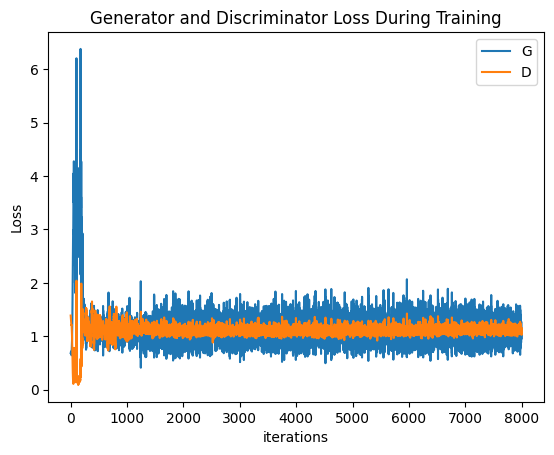

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.00018
beta1 = 0.5

# Setup Adam optimizers for both G and D

optimizerD =  optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG =  optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))


img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 20


def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################


        optimizerD.zero_grad()
        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)
        loss_D.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################


        optimizerG.zero_grad()
        loss_G = loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG)
        loss_G.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1



plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## 4. Qualitative Visualisations

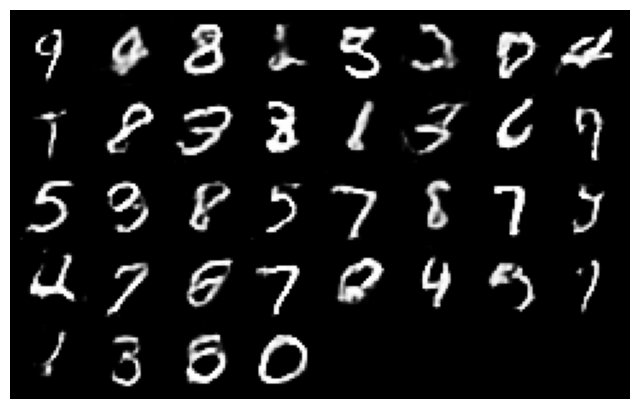

In [ ]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())